# K-Nearest Neighbor 

In [24]:
# Data Loading and Preprocessing 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data
train_df = pd.read_csv('csv/pokemon_train.csv')
test_df = pd.read_csv('csv/pokemon_test.csv')

# Prepare features and targets
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
X_train = train_df[features]
X_test = test_df[features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

In [37]:
# Baseline without CV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.neighbors import KNeighborsClassifier

# Primary Type
knn_primary = KNeighborsClassifier()
knn_primary.fit(X_train_scaled, y_train_primary)
y_pred_primary = knn_primary.predict(X_test_scaled)
print("KNN - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
knn_both = MultiOutputClassifier(KNeighborsClassifier())
knn_both.fit(X_train_scaled, y_train_both_bin)
y_pred_both = knn_both.predict(X_test_scaled)
print("KNN - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Generation
knn_generation = KNeighborsClassifier()
knn_generation.fit(X_train_scaled, y_train_generation)
y_pred_generation = knn_generation.predict(X_test_scaled)
print("KNN - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))

KNN - Primary Type Accuracy: 0.18048780487804877
KNN - Both Types Hamming Loss: 0.08590785907859079
KNN - Generation Accuracy: 0.1902439024390244


In [ ]:
# Model Implementation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

# Primary Type Prediction
knn_primary = KNeighborsClassifier()
# print(knn_primary.get_params())

# Both Types Prediction
knn_both = MultiOutputClassifier(KNeighborsClassifier())
# print(knn_both.get_params())

# Generation Prediction
knn_generation = KNeighborsClassifier()

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
{'estimator__algorithm': 'auto', 'estimator__leaf_size': 30, 'estimator__metric': 'minkowski', 'estimator__metric_params': None, 'estimator__n_jobs': None, 'estimator__n_neighbors': 5, 'estimator__p': 2, 'estimator__weights': 'uniform', 'estimator': KNeighborsClassifier(), 'n_jobs': None}


In [ ]:
# Results 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score

# Primary Type Prediction
print("Primary Type Prediction:")

# Before tuning
scores_primary_before = cross_val_score(knn_primary, X_train_scaled, y_train_primary, cv=5)
print(f"Before tuning - Mean CV score: {scores_primary_before.mean():.3f} (+/- {scores_primary_before.std() * 2:.3f})")

# After tuning
param_grid_primary = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
grid_search_primary = GridSearchCV(knn_primary, param_grid_primary, cv=5)
grid_search_primary.fit(X_train_scaled, y_train_primary)

print("Best parameters:", grid_search_primary.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_primary.best_score_:.3f}")

# Evaluate on test set
y_pred_primary = grid_search_primary.predict(X_test_scaled)
test_accuracy_primary = accuracy_score(y_test_primary, y_pred_primary)
print(f"Test set accuracy: {test_accuracy_primary:.3f}")

Primary Type Prediction:
Before tuning - Mean CV score: 0.163 (+/- 0.032)
Best parameters: {'n_neighbors': 11, 'weights': 'distance'}
After tuning - Best cross-validation score: 0.202
Test set accuracy: 0.185


In [ ]:
from sklearn.metrics import f1_score, hamming_loss, jaccard_score, accuracy_score

# Both Types Prediction
print("\nBoth Types Prediction:")

# Before tuning
scores_both_before = cross_val_score(knn_both, X_train_scaled, y_train_both_bin, cv=5, 
                                     scoring=make_scorer(hamming_loss, greater_is_better=False))
print(f"Before tuning - Mean CV Hamming Loss: {-scores_both_before.mean():.3f} (+/- {scores_both_before.std() * 2:.3f})")

# After tuning
param_grid_both = {'estimator__n_neighbors': [3, 5, 7, 9, 11], 'estimator__weights': ['uniform', 'distance']}
grid_search_both = GridSearchCV(knn_both, param_grid_both, cv=5, scoring=make_scorer(hamming_loss, greater_is_better=False))
grid_search_both.fit(X_train_scaled, y_train_both_bin)

print("Best parameters:", grid_search_both.best_params_)
print(f"After tuning - Best cross-validation Hamming Loss: {-grid_search_both.best_score_:.3f}")

# Evaluate on test set
y_pred_both = grid_search_both.predict(X_test_scaled)

# Hamming loss
# The fraction of labels that are incorrectly predicted
test_hamming_loss = hamming_loss(y_test_both_bin, y_pred_both)
print(f"Test set Hamming Loss: {test_hamming_loss:.3f}")

# Calculate exact match ratio
exact_matches = np.all(y_pred_both == y_test_both_bin, axis=1)
exact_match_ratio = np.mean(exact_matches)
print(f"Exact Match Ratio: {exact_match_ratio:.3f}")

# Jaccard similarity score
# The size of the intersection divided by the size of the union of two label sets
jaccard_score_value = jaccard_score(y_test_both_bin, y_pred_both, average='samples')
print(f"Jaccard Similarity Score: {jaccard_score_value:.3f}")

# F1-Score
f1_score_value = f1_score(y_test_both_bin, y_pred_both, average='samples')
print(f"F1 Score: {f1_score_value:.3f}")


Both Types Prediction:
Before tuning - Mean CV Hamming Loss: 0.094 (+/- 0.005)
Best parameters: {'estimator__n_neighbors': 11, 'estimator__weights': 'uniform'}
After tuning - Best cross-validation Hamming Loss: 0.086
Test set Hamming Loss: 0.082
Exact Match Ratio: 0.029
Jaccard Similarity Score: 0.034
F1 Score: 0.036


In [12]:
# Generation Prediction
print("\nGeneration Prediction:")

# Before tuning
scores_gen_before = cross_val_score(knn_generation, X_train_scaled, y_train_generation, cv=5)
print(f"Before tuning - Mean CV score: {scores_gen_before.mean():.3f} (+/- {scores_gen_before.std() * 2:.3f})")

# After tuning
param_grid_gen = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance']}
grid_search_gen = GridSearchCV(knn_generation, param_grid_gen, cv=5)
grid_search_gen.fit(X_train_scaled, y_train_generation)

print("Best parameters:", grid_search_gen.best_params_)
print(f"After tuning - Best cross-validation score: {grid_search_gen.best_score_:.3f}")

# Evaluate on test set
y_pred_gen = grid_search_gen.predict(X_test_scaled)
test_accuracy_gen = accuracy_score(y_test_generation, y_pred_gen)
print(f"Test set accuracy: {test_accuracy_gen:.3f}")


Generation Prediction:
Before tuning - Mean CV score: 0.170 (+/- 0.040)
Best parameters: {'n_neighbors': 11, 'weights': 'distance'}
After tuning - Best cross-validation score: 0.184
Test set accuracy: 0.210


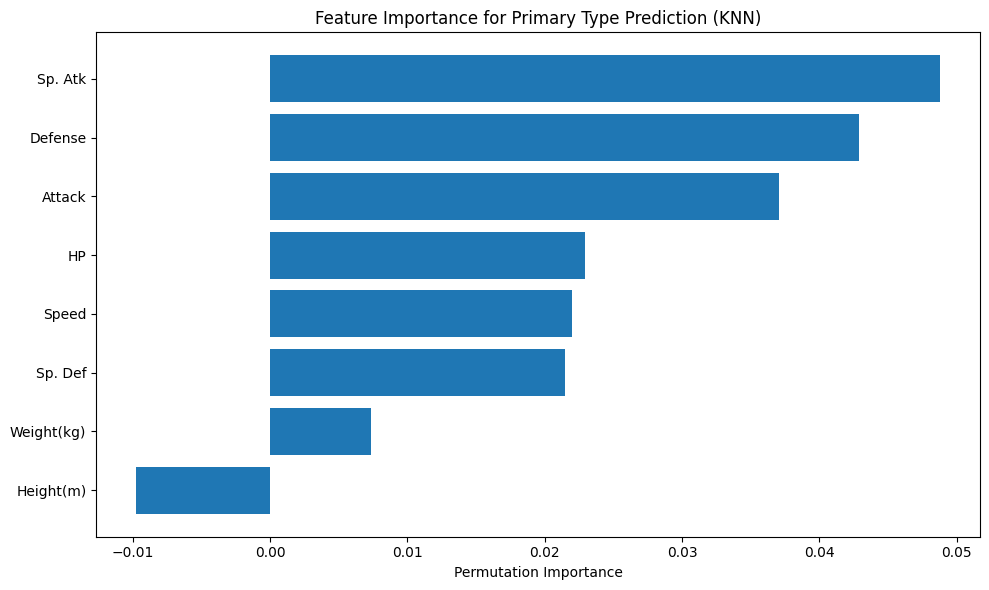

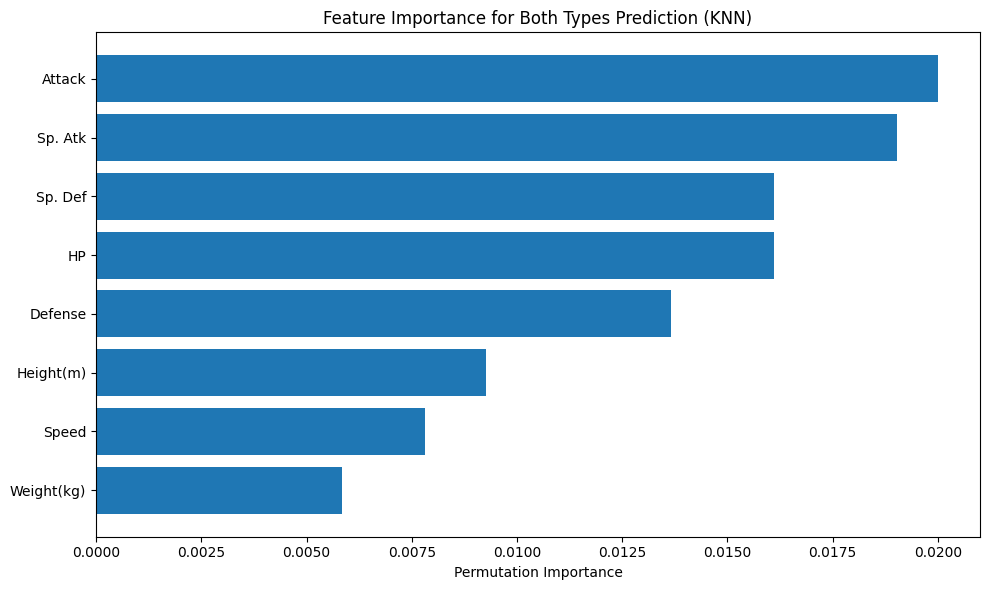

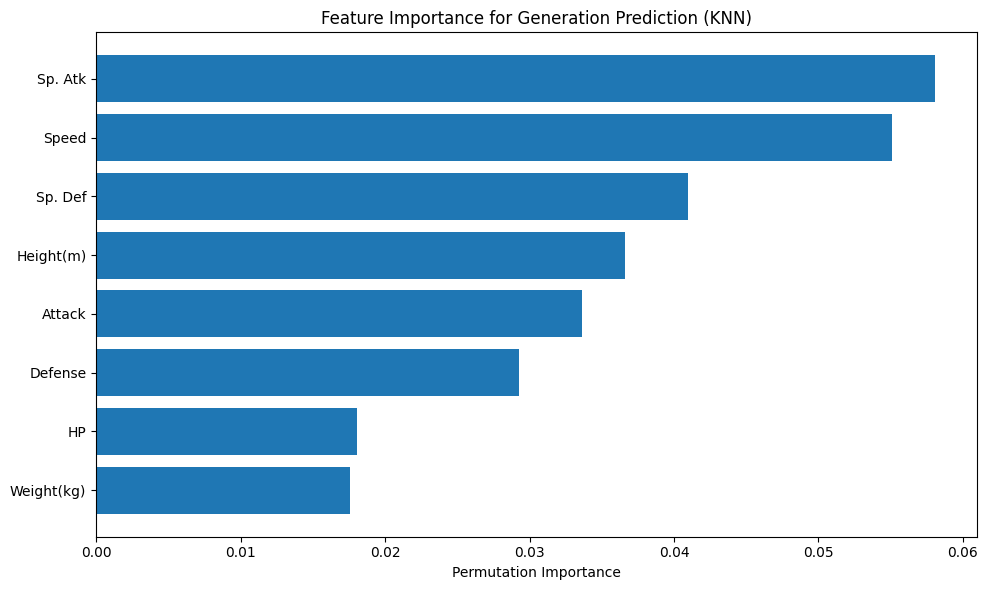

In [28]:
# Feature Importance (Permutation Importance)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

def plot_feature_importance(importance, title):
    sorted_idx = importance.argsort()
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(importance)), importance[sorted_idx])
    plt.yticks(range(len(importance)), [features[i] for i in sorted_idx])
    plt.xlabel('Permutation Importance')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Primary Type Feature Importance
result_primary = permutation_importance(grid_search_primary.best_estimator_, X_test_scaled, y_test_primary, n_repeats=10, random_state=42)
plot_feature_importance(result_primary.importances_mean, 'Feature Importance for Primary Type Prediction (KNN)')

# Both Types Feature Importance
result_both = permutation_importance(grid_search_both.best_estimator_, X_test_scaled, y_test_both_bin, n_repeats=10, random_state=42)
plot_feature_importance(result_both.importances_mean, 'Feature Importance for Both Types Prediction (KNN)')

# Generation Feature Importance
result_gen = permutation_importance(grid_search_gen.best_estimator_, X_test_scaled, y_test_generation, n_repeats=10, random_state=42)
plot_feature_importance(result_gen.importances_mean, 'Feature Importance for Generation Prediction (KNN)')

## Post Feature Engineering

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load the pre-split data with engineered features
train_df = pd.read_csv('engineered_csv/pokemon_train_engineered.csv')
test_df = pd.read_csv('engineered_csv/pokemon_test_engineered.csv')

# Define original and engineered features
original_features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Height(m)', 'Weight(kg)']
engineered_features = [
    'Attack_Defense_Ratio', 'SpAtk_SpDef_Ratio', 'Speed_Avg_Ratio',
    'Physical_Total', 'Special_Total', 'Offensive_Total', 'Defensive_Total',
    'Stat_StdDev', 'Stat_Range', 'Highest_Stat_Percentage', 'Top_Two_Stat_Difference',
    'Physical_Bulk', 'Special_Bulk', 'Survivability_Index', 'Offensive_Potential',
    'BMI', 'Weight_Height_Ratio', 'Relative_Power', 'Type_Rarity'
]

# Combine original and engineered features
all_features = original_features + engineered_features

# Prepare features
X_train = train_df[all_features]
X_test = test_df[all_features]

# Prepare targets
y_train_primary = train_df['Primary_Type']
y_test_primary = test_df['Primary_Type']
y_train_generation = train_df['Generation']
y_test_generation = test_df['Generation']

# Prepare both types for multi-label classification
y_train_both = train_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_test_both = test_df[['Primary_Type', 'Secondary_Type']].values.tolist()
y_train_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_train_both]
y_test_both = [[t[0], t[1]] if pd.notna(t[1]) else [t[0]] for t in y_test_both]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Binarize labels for multi-label classification
mlb = MultiLabelBinarizer()
y_train_both_bin = mlb.fit_transform(y_train_both)
y_test_both_bin = mlb.transform(y_test_both)

# Handle categorical features
categorical_features = ['Size_Class', 'Speed_Tier']
X_train_cat = pd.get_dummies(train_df[categorical_features], prefix=categorical_features)
X_test_cat = pd.get_dummies(test_df[categorical_features], prefix=categorical_features)

# Ensure test set has all columns present in train set
for col in X_train_cat.columns:
    if col not in X_test_cat.columns:
        X_test_cat[col] = 0

# Align columns of test set with train set
X_test_cat = X_test_cat[X_train_cat.columns]

# Combine scaled numerical features with categorical features
X_train_final = np.hstack((X_train_scaled, X_train_cat))
X_test_final = np.hstack((X_test_scaled, X_test_cat))

print("Training set shape:", X_train_final.shape)
print("Test set shape:", X_test_final.shape)
print("Number of classes for multi-label classification:", len(mlb.classes_))

Training set shape: (820, 35)
Test set shape: (205, 35)
Number of classes for multi-label classification: 18


In [3]:
# Baseline without CV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.neighbors import KNeighborsClassifier

# Primary Type
knn_primary = KNeighborsClassifier()
knn_primary.fit(X_train_final, y_train_primary)
y_pred_primary = knn_primary.predict(X_test_final)
print("KNN - Primary Type Accuracy:", accuracy_score(y_test_primary, y_pred_primary))

# Both Types
knn_both = MultiOutputClassifier(KNeighborsClassifier())
knn_both.fit(X_train_final, y_train_both_bin)
y_pred_both = knn_both.predict(X_test_final)
print("KNN - Both Types Hamming Loss:", hamming_loss(y_test_both_bin, y_pred_both))

# Generation
knn_generation = KNeighborsClassifier()
knn_generation.fit(X_train_final, y_train_generation)
y_pred_generation = knn_generation.predict(X_test_final)
print("KNN - Generation Accuracy:", accuracy_score(y_test_generation, y_pred_generation))


KNN - Primary Type Accuracy: 0.17560975609756097
KNN - Both Types Hamming Loss: 0.08915989159891599
KNN - Generation Accuracy: 0.16585365853658537
